In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
import keras
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array

In [3]:
path='C:/Users/user/Desktop/Age and Gender/super_resol_data/Humans'

def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    return images
images=images_upload(path)

100%|█████████████████████████████████████████████████████████████████████████| 7219/7219 [00:00<00:00, 1795888.53it/s]


In [4]:
HSIZE =128
LSIZE =32

In [5]:
def convert_high_image_labels(images):
    high_labels=[]
    j=0
    for i in tqdm(images):
        if(j==7000):
            break
        i = cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        res_i=cv2.resize(i,(HSIZE,HSIZE))
        res_i = res_i.astype('float32') / 255.0

        del i
        high_labels.append(img_to_array(res_i))
        j = j+1
    return high_labels
high_labels = convert_high_image_labels(images)

 98%|████████████████████████████████████████████████████████████████████████████▋ | 7000/7123 [02:23<00:02, 48.65it/s]


In [6]:
def convert_low_image_labels(images):
    low_labels=[]
    j=0
    for i in tqdm(images):
        if(j==7000):
            break
        i = cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        res_i=cv2.resize(i,(LSIZE,LSIZE))
        res_i = res_i.astype('float32') / 255.0
        del i
        j= j+1
        low_labels.append(img_to_array(res_i))
    return low_labels
low_labels = convert_low_image_labels(images)

 98%|████████████████████████████████████████████████████████████████████████████▋ | 7000/7123 [01:59<00:02, 58.41it/s]


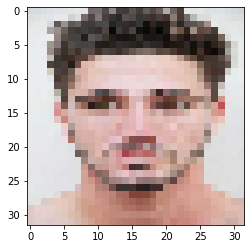

In [7]:
low_labels[0].shape
plt.imshow(low_labels[0])

In [8]:

from keras import layers
def down(filters , kernel_low_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_low_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_low_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_low_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [LSIZE,LSIZE,3])
    print(inputs.shape)
    d1 = down(128,(3,3),False)(inputs)
    print(d1.shape)
    d2 = down(128,(3,3),False)(d1)
    print(d2.shape)
    d3 = down(256,(3,3),True)(d2)
    print(d3.shape)
#     d4 = down(512,(3,3),True)(d3)
#     print(d4.shape,"d4")
    
# #     d5 = down(512,(3,3),True)(d4)
# #     print(d5.shape)
# #     #upsampling
# #     u1 = up(512,(3,3),False)(d5)
# #     print(u1.shape)
# #     u1 = layers.concatenate([u1,d4])
#     u2 = up(256,(3,3),False)(d4)
#     print(u2.shape,"u2")
#     u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(d3)
    print(u3.shape,"u3")
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(128,(3,3),False)(u4)
    u6 = up(64,(3,3),False)(u5)
    u7 = up(3,(3,3),False)(u6)
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u7)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

(None, 32, 32, 3)
(None, 16, 16, 128)
(None, 8, 8, 128)
(None, 4, 4, 256)
(None, 8, 8, 128) u3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 16, 16, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 8, 8, 128)    147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 4, 256)    296192      ['sequential_1[0][0]']           

In [9]:
len(high_labels)

7000

In [10]:

train_high_image = high_labels[:6000]
train_low_image = low_labels[:6000]
validation_high_image = high_labels[6000:]
validation_low_image = low_labels[6000:]

# train_high_image = np.reshape(train_high_image,(len(train_high_image),HSIZE,HSIZE,3))
# train_low_image = np.reshape(train_low_image,(len(train_low_image),LSIZE,LSIZE,3))


# validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),HSIZE,HSIZE,3))
# validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),LSIZE,LSIZE,3))


# test_high_image = high_labels[6500:]
# test_low_image = low_labels[6500:]
# test_high_image= np.reshape(test_high_image,(len(test_high_image),HSIZE,HSIZE,3))
# test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

# print("Shape of training images:",train_high_image.shape)
# # print("Shape of test images:",test_high_image.shape)
# print("Shape of validation images:",validation_high_image.shape)

In [11]:
high_labels.clear()
low_labels.clear()

In [12]:

train_high_image = np.reshape(train_high_image[:6000],(6000,HSIZE,HSIZE,3))
train_low_image = np.reshape(train_low_image[:6000],(6000,LSIZE,LSIZE,3))


validation_high_image= np.reshape(validation_high_image[:1000],(1000,HSIZE,HSIZE,3))
validation_low_image = np.reshape(validation_low_image[:1000],(1000,LSIZE,LSIZE,3))


In [13]:
print(train_high_image.shape)
print(train_low_image.shape)
print(validation_high_image.shape)
print(validation_low_image.shape)

(6000, 128, 128, 3)
(6000, 32, 32, 3)
(1000, 128, 128, 3)
(1000, 32, 32, 3)


In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])
H =model.fit(train_low_image, train_high_image, epochs = 30, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/30
6000/6000 [==============================] - 111s 18ms/step - loss: 0.0561 - acc: 0.7594 - val_loss: 0.0472 - val_acc: 0.8453
Epoch 2/30
6000/6000 [==============================] - 106s 18ms/step - loss: 0.0459 - acc: 0.8002 - val_loss: 0.0423 - val_acc: 0.8540
Epoch 3/30
6000/6000 [==============================] - 104s 17ms/step - loss: 0.0429 - acc: 0.8081 - val_loss: 0.0418 - val_acc: 0.8620
Epoch 4/30
6000/6000 [==============================] - 104s 17ms/step - loss: 0.0408 - acc: 0.8112 - val_loss: 0.0424 - val_acc: 0.8486
Epoch 5/30
6000/6000 [==============================] - 105s 18ms/step - loss: 0.0397 - acc: 0.8124 - val_loss: 0.0465 - val_acc: 0.8573
Epoch 6/30
6000/6000 [==============================] - 107s 18ms/step - loss: 0.0390 - acc: 0.8145 - val_loss: 0.0419 - val_acc: 0.8726
Epoch 7/30
6000/6000 [==============================] - 107s 18ms/step - loss: 0.0381 - acc: 0.8153 - val_loss: 0.0488 - val_acc: 0.8881
Epoch 8/30
6000/6000 [===================

In [15]:
new_low_images = model.predict(train_low_image)

188/188 [==============================] - 16s 86ms/step


In [16]:
new_validation_low_image = model.predict(validation_low_image)

32/32 [==============================] - 3s 82ms/step


In [17]:

def second_model():
    inputs = layers.Input(shape= [HSIZE,HSIZE,3])
    print(inputs.shape)
    d1 = down(128,(3,3),False)(inputs)
    print(d1.shape)
    d2 = down(128,(3,3),False)(d1)
    print(d2.shape)
    d3 = down(256,(3,3),True)(d2)
    print(d3.shape)
    d4 = down(512,(3,3),True)(d3)
    print(d4.shape)
    
#     d5 = down(512,(3,3),True)(d4)
#     print(d5.shape)
#     #upsampling
#     u1 = up(512,(3,3),False)(d5)
#     print(u1.shape)
#     u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(d4)
    print(u2.shape)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    print(u3.shape)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

smodel = second_model()
smodel.summary()

(None, 128, 128, 3)
(None, 64, 64, 128)
(None, 32, 32, 128)
(None, 16, 16, 256)
(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_8 (Sequential)      (None, 64, 64, 128)  3584        ['input_2[0][0]']                
                                                                                                  
 sequential_9 (Sequential)      (None, 32, 32, 128)  147584      ['sequential_8[0][0]']           
                                                     

In [18]:
smodel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])
h= smodel.fit(new_low_images, train_high_image, epochs = 20, batch_size = 1,
          validation_data = (new_validation_low_image,validation_high_image))

Epoch 1/20
6000/6000 [==============================] - 292s 49ms/step - loss: 0.0412 - acc: 0.7883 - val_loss: 0.0419 - val_acc: 0.8455
Epoch 2/20
6000/6000 [==============================] - 291s 49ms/step - loss: 0.0351 - acc: 0.8204 - val_loss: 0.0398 - val_acc: 0.8602
Epoch 3/20
6000/6000 [==============================] - 293s 49ms/step - loss: 0.0345 - acc: 0.8213 - val_loss: 0.0384 - val_acc: 0.8951
Epoch 4/20
6000/6000 [==============================] - 294s 49ms/step - loss: 0.0337 - acc: 0.8260 - val_loss: 0.0386 - val_acc: 0.8660
Epoch 5/20
6000/6000 [==============================] - 298s 50ms/step - loss: 0.0330 - acc: 0.8262 - val_loss: 0.0399 - val_acc: 0.9037
Epoch 6/20
6000/6000 [==============================] - 301s 50ms/step - loss: 0.0323 - acc: 0.8315 - val_loss: 0.0379 - val_acc: 0.9125
Epoch 7/20
6000/6000 [==============================] - 302s 50ms/step - loss: 0.0316 - acc: 0.8323 - val_loss: 0.0419 - val_acc: 0.8471
Epoch 8/20
6000/6000 [===================

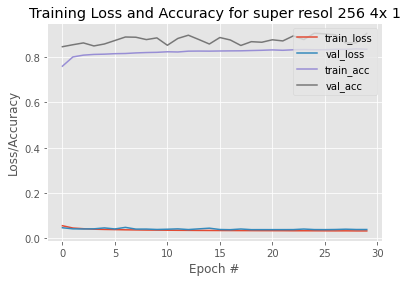

In [20]:
plt.style.use("ggplot")
plt.figure()
N = 30
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy for super resol 256 4x 1")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('super resol 256 1x 1.png')

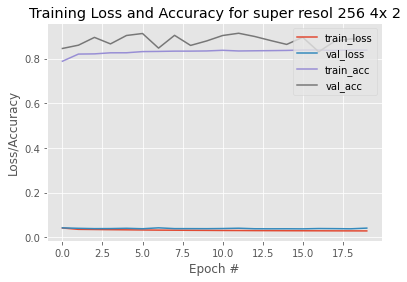

In [21]:
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), h.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), h.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy for super resol 256 4x 2")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('super resol 256 1x 2.png')

1/1 [==============================] - 0s 129ms/step


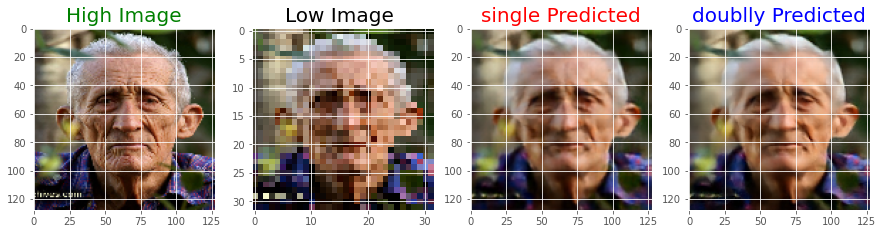

1/1 [==============================] - 0s 26ms/step


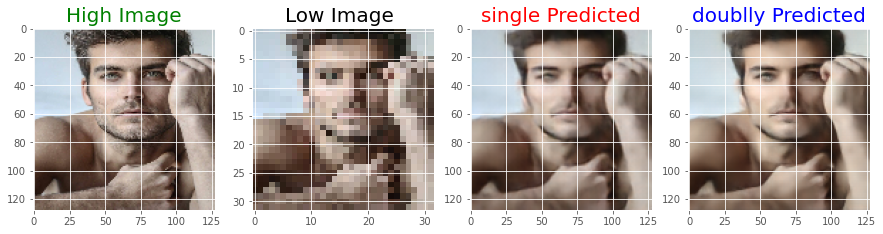

1/1 [==============================] - 0s 30ms/step


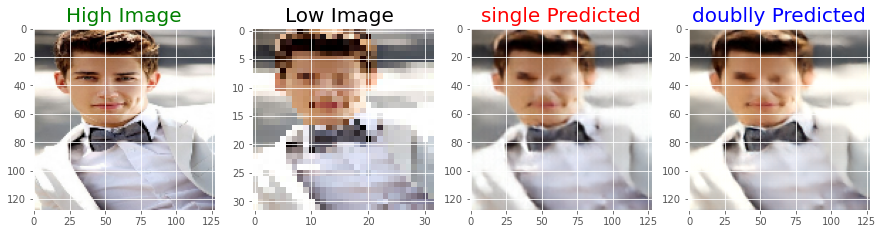

1/1 [==============================] - 0s 25ms/step


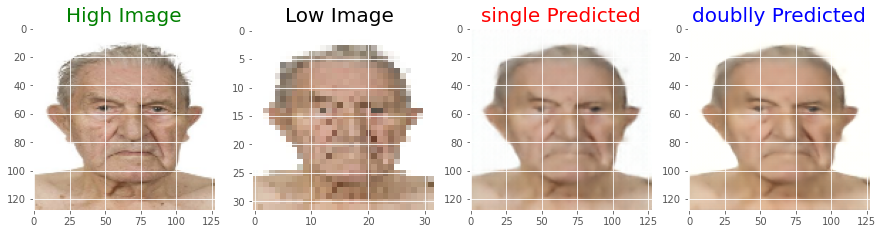

1/1 [==============================] - 0s 29ms/step


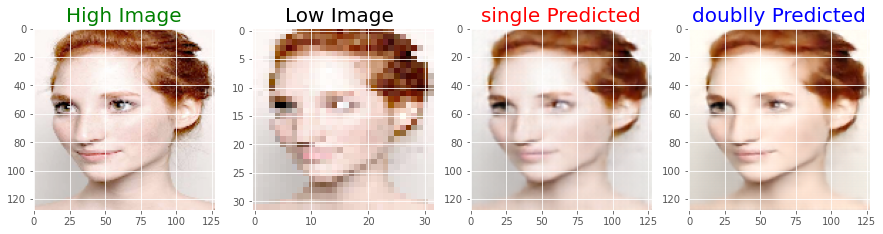

1/1 [==============================] - 0s 26ms/step


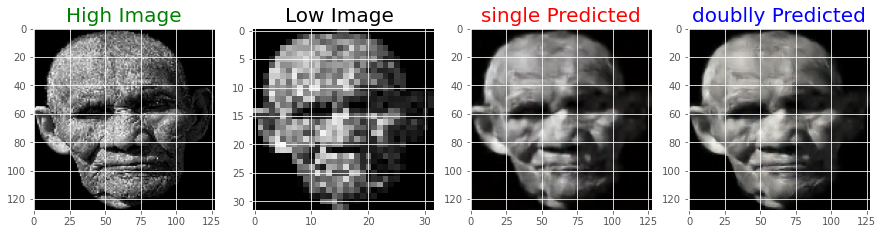

1/1 [==============================] - 0s 25ms/step


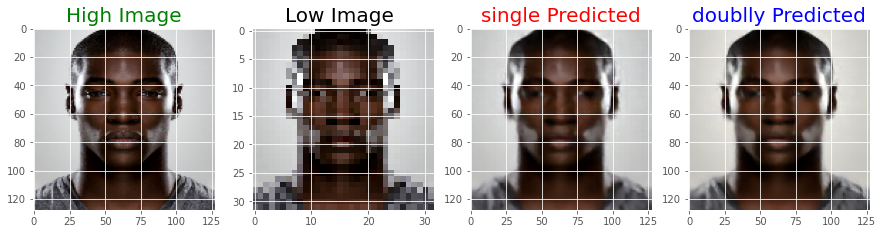

1/1 [==============================] - 0s 25ms/step


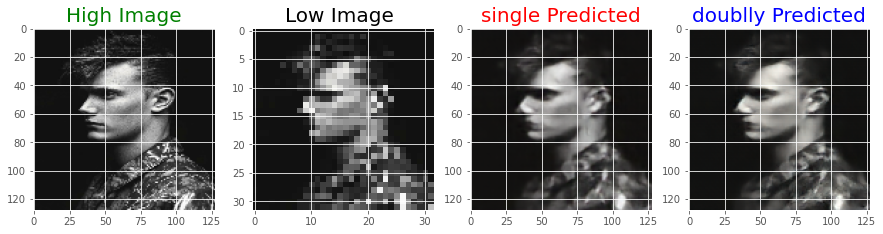

1/1 [==============================] - 0s 26ms/step


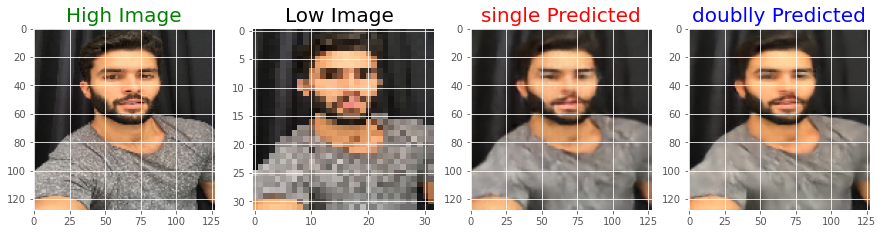

In [22]:
def plot_images(high,low,predicted1,predicted2):
    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,4,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,4,3)
    plt.title('single Predicted', color = 'Red', fontsize = 20)
    plt.imshow(predicted1)
    plt.subplot(1,4,4)
    plt.title('doublly Predicted', color = 'blue', fontsize = 20)
    plt.imshow(predicted2)
    
    plt.show()

for i in range(1,10):
    
    predicted1 = np.clip(model.predict(train_low_image[i].reshape(1,LSIZE, LSIZE,3)),0.0,1.0).reshape(HSIZE, HSIZE,3)
    predicted2 = np.clip(smodel.predict(predicted1.reshape(1,HSIZE, HSIZE,3)),0.0,1.0).reshape(HSIZE, HSIZE,3)
    
    plot_images(train_high_image[i],train_low_image[i],predicted1,predicted2)

In [23]:
model.save("high_resol1_128_1x.model")
smodel.save("high_resol2_128_1x.model")

INFO:tensorflow:Assets written to: high_resol1_128_1x.model\assets


INFO:tensorflow:Assets written to: high_resol1_128_1x.model\assets


INFO:tensorflow:Assets written to: high_resol2_128_1x.model\assets


INFO:tensorflow:Assets written to: high_resol2_128_1x.model\assets
